<h3>Kernel Density Estimation</h3>

This section will use the Kernel Density Estimation (KDE) methods to identify locations in San Francisco (SF) that see the highest amount of bike crashes. The KDE method combined with GeoPandas will help visualize crash hotspots around SF. 

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from math import radians
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [6]:
crashes = pd.read_csv("data/Crashes.csv")
crashes = crashes.dropna(subset=['POINT_X', 'POINT_Y'])

In [7]:
#Cleaning data set so that latitudinal and longitudinal outliers are ignored
crashes_clean = crashes[
    (crashes['POINT_X'] > -123) & (crashes['POINT_X'] < -121) &  # reasonable longitudes
    (crashes['POINT_Y'] > 37)   & (crashes['POINT_Y'] < 38.5) ].copy()   # reasonable latitudes

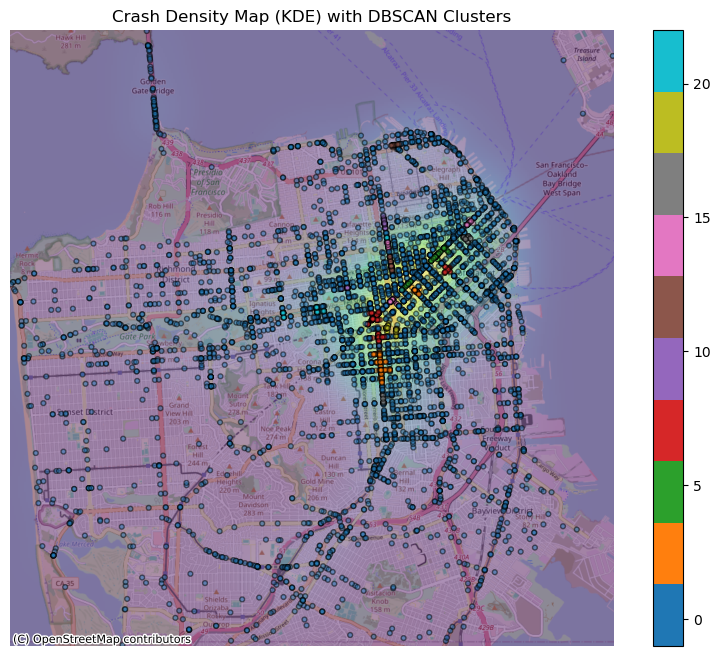

In [8]:
# Turn latitude and longitude into radians for the DBSCAN Haversine method
crashes_clean['lat_rad'] = crashes_clean['POINT_Y'].apply(radians)
crashes_clean['lon_rad'] = crashes_clean['POINT_X'].apply(radians)
coords_rad = crashes_clean[['lat_rad', 'lon_rad']].values

# Mark radius of the cluster
eps_meters = 100
eps_radians = eps_meters / 6371000.0

#Run DBSCAN, defining how many crashes will be in a cluster, noting haversine method
db = DBSCAN(
    eps=eps_radians,
    min_samples=20,
    metric='haversine'
).fit(coords_rad)  

#Set cluster IDs
crashes_clean['cluster'] = db.labels_

# Build points given geometry of crashes
crashes_clean['geometry'] = crashes_clean.apply(
    lambda row: Point(row['POINT_X'], row['POINT_Y']),
    axis=1 )

# Get geodata frame to plot on map
gdf = gpd.GeoDataFrame(crashes_clean, geometry='geometry', crs='EPSG:4326')

# Reproject to turn from radians into meters for map
gdf = gdf.to_crs(epsg=3857)

# Get projected points for KDE analysis
x = gdf.geometry.x.values
y = gdf.geometry.y.values

# Build grid over study area for eventual figure and KDE density surface
xmin, ymin, xmax, ymax = gdf.total_bounds
xi, yi = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]

# Run KDE
kde = gaussian_kde([x, y]) 
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
zi = zi.reshape(xi.shape)

# Figure with clusters, mesh, and underlying map
fig, ax = plt.subplots(figsize=(10, 8))

ax.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis', alpha=0.45)

# Points colored by cluster label
gdf.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=12,
    alpha=0.5,
    edgecolor='black',
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Crash Density Map (KDE) with DBSCAN Clusters")
plt.show()


Now, lets just look at fatal crashes

In [9]:
crashes_clean.columns

Index(['CASE_ID', 'ACCIDENT_YEAR', 'PROC_DATE', 'JURIS', 'COLLISION_DATE',
       'COLLISION_TIME', 'OFFICER_ID', 'REPORTING_DISTRICT', 'DAY_OF_WEEK',
       'CHP_SHIFT', 'POPULATION', 'CNTY_CITY_LOC', 'SPECIAL_COND', 'BEAT_TYPE',
       'CHP_BEAT_TYPE', 'CITY_DIVISION_LAPD', 'CHP_BEAT_CLASS', 'BEAT_NUMBER',
       'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION',
       'WEATHER_1', 'WEATHER_2', 'STATE_HWY_IND', 'CALTRANS_COUNTY',
       'CALTRANS_DISTRICT', 'STATE_ROUTE', 'ROUTE_SUFFIX', 'POSTMILE_PREFIX',
       'POSTMILE', 'LOCATION_TYPE', 'RAMP_INTERSECTION', 'SIDE_OF_HWY',
       'TOW_AWAY', 'COLLISION_SEVERITY', 'NUMBER_KILLED', 'NUMBER_INJURED',
       'PARTY_COUNT', 'PRIMARY_COLL_FACTOR', 'PCF_CODE_OF_VIOL',
       'PCF_VIOL_CATEGORY', 'PCF_VIOLATION', 'PCF_VIOL_SUBSECTION',
       'HIT_AND_RUN', 'TYPE_OF_COLLISION', 'MVIW', 'PED_ACTION',
       'ROAD_SURFACE', 'ROAD_COND_1', 'ROAD_COND_2', 'LIGHTING',
       'CONTROL_DEVICE', 'CHP_ROAD_TYPE', 'PEDESTRIAN_

In [10]:
crashes_fatal = crashes_clean[crashes_clean['COUNT_BICYCLIST_KILLED'] > 0]


/tmp/ipykernel_678/3009314002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_fatal['lat_rad'] = crashes_fatal['POINT_Y'].apply(radians)
/tmp/ipykernel_678/3009314002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_fatal['lon_rad'] = crashes_fatal['POINT_X'].apply(radians)
/tmp/ipykernel_678/3009314002.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

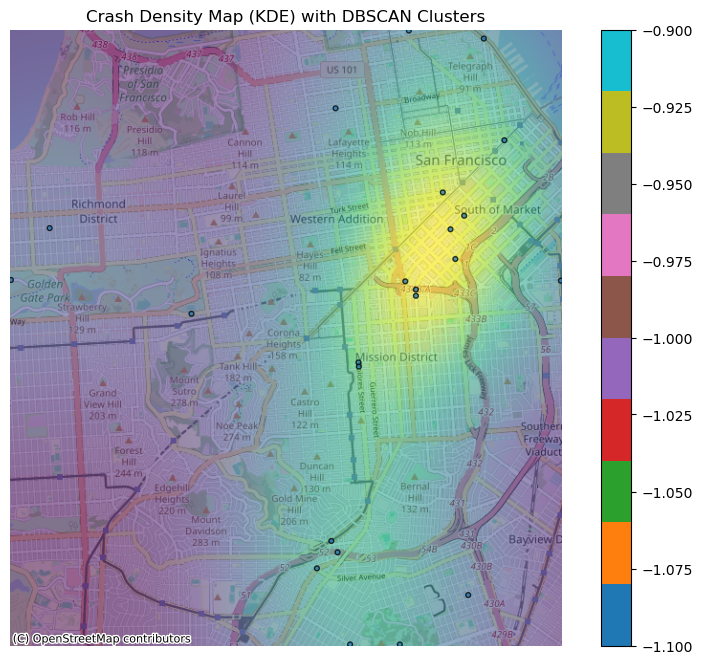

In [11]:
# Turn latitude and longitude into radians for the DBSCAN Haversine method
crashes_fatal['lat_rad'] = crashes_fatal['POINT_Y'].apply(radians)
crashes_fatal['lon_rad'] = crashes_fatal['POINT_X'].apply(radians)
coords_rad = crashes_fatal[['lat_rad', 'lon_rad']].values

# Mark radius of the cluster
eps_meters = 50
eps_radians = eps_meters / 6371000.0

#Run DBSCAN, defining how many crashes will be in a cluster, noting haversine method
db = DBSCAN(
    eps=eps_radians,
    min_samples=5,
    metric='haversine'
).fit(coords_rad)  

#Set cluster IDs
crashes_fatal['cluster'] = db.labels_

# Build points given geometry of crashes
crashes_fatal['geometry'] = crashes_fatal.apply(
    lambda row: Point(row['POINT_X'], row['POINT_Y']),
    axis=1 )

# Get geodata frame to plot on map
gdf = gpd.GeoDataFrame(crashes_fatal, geometry='geometry', crs='EPSG:4326')

# Reproject to turn from radians into meters for map
gdf = gdf.to_crs(epsg=3857)

# Get projected points for KDE analysis
x = gdf.geometry.x.values
y = gdf.geometry.y.values

# Build grid over study area for eventual figure and KDE density surface
xmin, ymin, xmax, ymax = gdf.total_bounds
xi, yi = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]

# Run KDE
kde = gaussian_kde([x, y]) 
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
zi = zi.reshape(xi.shape)

# Figure with clusters, mesh, and underlying map
fig, ax = plt.subplots(figsize=(10, 8))

ax.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis', alpha=0.55)

# Points colored by cluster label
gdf.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=12,
    alpha=0.75,
    edgecolor='black',
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Crash Density Map (KDE) with DBSCAN Clusters")
plt.show()


We will need to look at proportions of crashes that occur in each aream but maybe also we can look at physical attributes

In [12]:
gdf

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y,lat_rad,lon_rad,cluster,geometry
182,6854093,2014,2016-01-14,3801,2014-05-25,2113,1939,NORTH,7,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.430027,37.795143,0.659650,-2.136807,-1,POINT (-13628848.306 4550526.631)
413,6292204,2015,2015-06-02,3801,2015-03-02,1234,1324,MISSI,1,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.415610,37.768540,0.659185,-2.136555,-1,POINT (-13627243.364 4546779.678)
542,7200147,2017,2018-06-14,3801,2017-04-28,1128,595,SOUTH,5,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.389580,37.770690,0.659223,-2.136101,-1,POINT (-13624345.71 4547082.455)
931,7006657,2015,2017-03-30,3801,2015-10-11,1522,001994,CENTR,7,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.399717,37.790615,0.659571,-2.136278,-1,POINT (-13625474.184 4549888.778)
1248,8404368,2017,2017-07-28,3801,2017-06-20,1734,1730,INGLE,2,5,...,37.729830,-122.433190,SAN FRANCISCO,SAN FRANCISCO,-122.433380,37.729850,0.658510,-2.136866,-1,POINT (-13629221.51 4541332.652)
1711,94489051,2023,2024-12-02,9335,2023-10-14,25,023067,NaN,6,3,...,37.732059,-122.429703,SAN FRANCISCO,SAN FRANCISCO,-122.429680,37.732128,0.658550,-2.136801,-1,POINT (-13628809.621 4541653.31)
1714,9453970,2022,2023-02-09,3801,2022-06-23,802,9,CENTR,4,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.416878,37.806179,0.659842,-2.136578,-1,POINT (-13627384.495 4552081.479)
1829,6293010,2016,2017-12-06,3801,2016-06-22,2024,373,SOUTH,3,5,...,37.777900,-122.409560,SAN FRANCISCO,SAN FRANCISCO,-122.409400,37.777980,0.659350,-2.136447,-1,POINT (-13626552.067 4548109.132)
1900,6854743,2015,2016-06-02,3801,2015-06-06,2102,578,NaN,6,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.427423,37.719042,0.658321,-2.136762,-1,POINT (-13628558.406 4539811.585)
1946,7006441,2015,2017-04-04,3801,2015-12-14,1015,518,BAYVI,1,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.406222,37.726052,0.658444,-2.136392,-1,POINT (-13626198.272 4540798.04)
